### generic model for face detection (based on an object detection model)
### model
- `VGG16` - predefined model for object detection
- input 
    - image [200 x 200]
- output 
    - [0,1] - 0 if face is not present on the image, 1 otherwise
    - x,y,w,h - coordinates of the face on the image
### dictionary
- bounding box - box that marks area where our object is present (in our case face)
### libraries 
- `labelme` - Library that contains method that we will use to label data


In [52]:
import tensorflow as tf
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [53]:
IMAGE_SIZE = 120
BATCH_SIZE = 8

In [54]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [55]:
def conver_data(images):
    images = images.map(load_image)
    images = images.map(lambda x: tf.image.resize(x, (IMAGE_SIZE,IMAGE_SIZE)))
    images = images.map(lambda x: x/255) 
    return images

In [56]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = conver_data(train_images)
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = conver_data(test_images)
train_images.as_numpy_iterator().next().shape

(120, 120, 3)

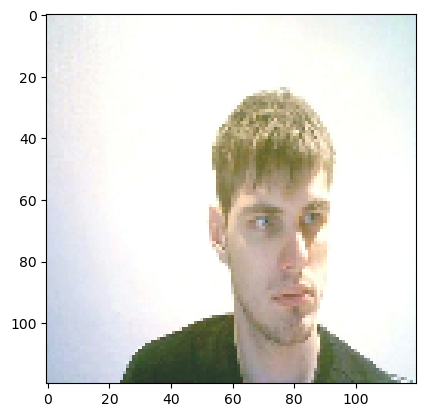

In [57]:
plt.imshow(train_images.as_numpy_iterator().next())

In [58]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [59]:

train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [60]:

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [61]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.517 , 0.341 , 0.7676, 0.887 ], dtype=float16))

In [62]:
len(train_images), len(train_labels), len(test_images), len(test_labels)

(1980, 1980, 360, 360)

In [63]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(BATCH_SIZE)
train = train.prefetch(4)

In [64]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(BATCH_SIZE)
test = test.prefetch(4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(120, 120, 3)
(120, 120, 3)
(120, 120, 3)
(120, 120, 3)


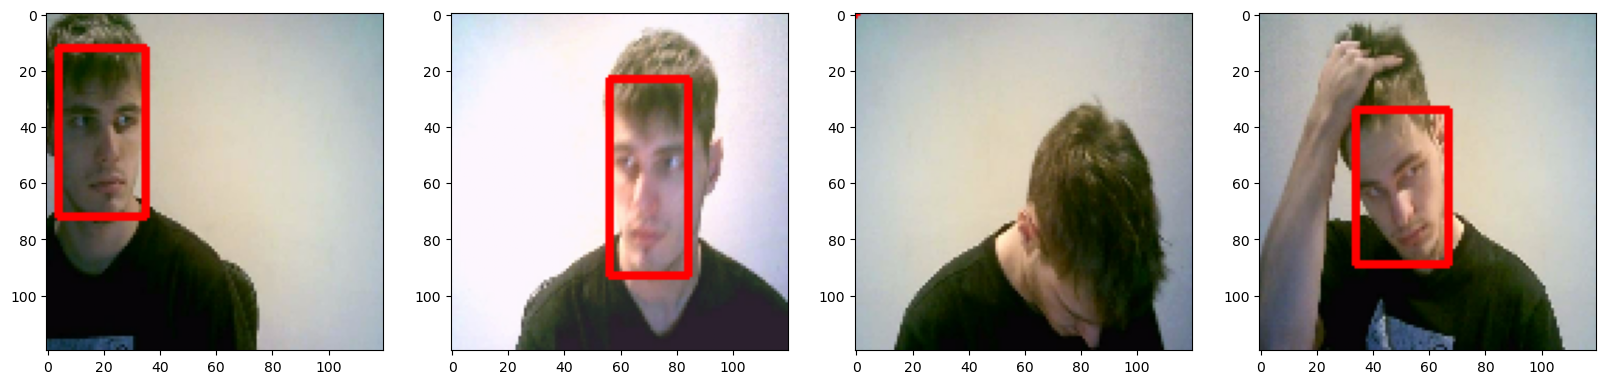

In [65]:
data_samples = train.as_numpy_iterator()

res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [IMAGE_SIZE,IMAGE_SIZE]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [IMAGE_SIZE,IMAGE_SIZE]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)
    print(sample_image.shape)

# data is now prepared, now we can train our model

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Add
from tensorflow.keras.applications import VGG16 # our pretrained model for image classification
from tensorflow.keras.optimizers import Adam

In [67]:
vgg = VGG16(include_top=False) # we will use the pretrained model without the top layers. We will add our own layers for classification
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Our model will have 2 outputs
### **each output has to have different loss func**
- first one class of the image (0 or 1) - if face is present or not
- second one bounding box of the face on the image

In [68]:
def build_model(): 
    input_layer = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    class1 = GlobalMaxPooling2D()(vgg)
    class2 = Dense(2048, activation='relu')(class1)
    class3 = Dense(1, activation='sigmoid')(class2)
    
    # Bounding box model
    regress1 = GlobalMaxPooling2D()(vgg)
    regress2 = Dense(2048, activation='relu')(regress1)
    regress3 = Dense(4, activation='sigmoid')(regress2)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [69]:
facetracker = build_model()
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_5[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [70]:
X, y = train.as_numpy_iterator().next()

In [71]:
batches_per_epoch = len(train_images) // 8  # slowing down the training to prevent overfitting
lr_decay = (1./.53 - 1.)/batches_per_epoch

In [72]:
opt = Adam(learning_rate=0.0001, decay=lr_decay)

#### now we will define loss func for bounder box basing on (YOLO func)

In [73]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    height_true = y_true[:,3] - y_true[:,1] 
    width_true = y_true[:,2] - y_true[:,0] 

    height_pred = yhat[:,3] - yhat[:,1] 
    width_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(width_true - width_pred) + tf.square(height_true-height_pred))
    
    return delta_coord + delta_size

In [74]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regress_loss = localization_loss

In [75]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))# update the weights
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [76]:
model = FaceTracker(facetracker)
model.compile(opt, class_loss, regress_loss)

In [77]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs", histogram_freq=1)


In [79]:
hist = model.fit(train, epochs=4, validation_data=test, callbacks=[tensorboard_callback])

Epoch 1/4
248/248 [==============================] - 379s 2s/step - total_loss: 2.9633 - class_loss: 1.7660 - regress_loss: 2.0803 - val_total_loss: 3.3260 - val_class_loss: 2.2371 - val_regress_loss: 2.2074
Epoch 2/4
248/248 [==============================] - 374s 2s/step - total_loss: 2.9576 - class_loss: 1.7622 - regress_loss: 2.0765 - val_total_loss: 3.6091 - val_class_loss: 2.2370 - val_regress_loss: 2.4906
Epoch 3/4
  9/248 [>.............................] - ETA: 5:28 - total_loss: 2.7946 - class_loss: 1.6781 - regress_loss: 1.9556

KeyboardInterrupt: 